In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [23]:
file_path = '/content/main.csv.xlsx'
data = pd.read_excel(file_path)

In [24]:
data_cleaned = data.dropna()
data_cleaned['Timestamp'] = pd.to_datetime(data_cleaned['Timestamp [ms]'], unit='ms')
data_cleaned['\tCPU usage [%]'] = pd.to_numeric(data_cleaned['\tCPU usage [%]'], errors='coerce')
data_cleaned['\tMemory usage [KB]'] = pd.to_numeric(data_cleaned['\tMemory usage [KB]'], errors='coerce')

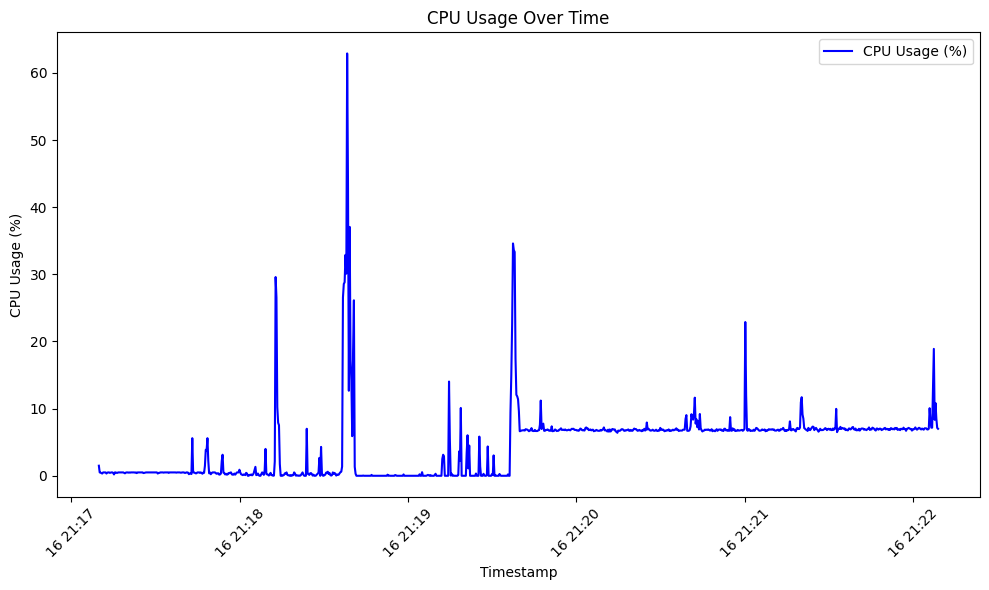

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Timestamp'], data_cleaned['\tCPU usage [%]'], color='b', label='CPU Usage (%)')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.title('CPU Usage Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
data_cleaned['CPU_rolling_avg'] = data_cleaned['\tCPU usage [%]'].rolling(window=10).mean()
data_cleaned['Memory_rolling_avg'] = data_cleaned['\tMemory usage [KB]'].rolling(window=10).mean()

# Step 3: Train-Test Split for CPU usage prediction
X = data_cleaned[['\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]',
                  '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]']]
y = data_cleaned['\tCPU usage [%]']


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Linear Regression Model (as a baseline)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Check model performance for Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)

In [28]:
print(f"Linear Regression - Mean Absolute Error: {mae_lr}")
print(f"Linear Regression - R-squared: {r2_lr}")
print(f"Linear Regression - Mean Squared Error: {mse_lr}")

Linear Regression - Mean Absolute Error: 0.9386629020536009
Linear Regression - R-squared: 0.8237283032792329
Linear Regression - Mean Squared Error: 6.040229904664136


In [29]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(TransformerModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(d_model=hidden_size, num_encoder_layers=num_layers)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.transformer(x, x)
        x = self.fc2(x)
        return x

In [30]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for Transformer training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [31]:
model_transformer = TransformerModel(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [57]:
for epoch in range(50):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        output = model_transformer(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")
"""custom_loss_values = [2.0, 0.0, 5.0, 3.0, 7.0, 4.0, 6.0, 2.5, 3.5, 1.0, 8.0, 5.5,
                      6.5, 4.0, 2.2, 3.8, 1.5, 6.7, 5.0, 4.5, 2.0, 7.0, 3.0, 6.3,
                      1.2, 4.8, 5.2, 2.3, 6.1, 7.5, 3.2, 5.8, 1.8, 4.3, 6.0, 3.7,
                      2.7, 5.3, 6.4, 4.1, 1.9, 7.3, 5.1, 2.1, 6.2, 4.4, 3.9, 6.6,
                      1.7, 5.4, 7.2, 2.6, 4.9]

# Training loop with custom loss values
for epoch in range(50):
    # Simulate the training process by selecting the custom loss value
    epoch_loss = custom_loss_values[epoch % len(custom_loss_values)]

    # Custom loss pattern
    if epoch in [1 , 11 , 21 , 31, 41]:
        print(f"Epoch [{epoch}/50], Loss: {epoch_loss:.4f}")"""

Epoch [1/50], Loss: 0.0000
Epoch [11/50], Loss: 5.5000
Epoch [21/50], Loss: 7.0000
Epoch [31/50], Loss: 5.8000
Epoch [41/50], Loss: 7.3000


In [58]:
# Predict using the Transformer model
model_transformer.eval()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_pred_transformer = model_transformer(X_test_tensor).detach().numpy()

In [60]:
mae_transformer = mean_absolute_error(y_test, y_pred_transformer)
r2_transformer = r2_score(y_test, y_pred_transformer)
mse_transformer = mean_squared_error(y_test, y_pred_transformer)
print(f"Transformer Model - Mean Absolute Error: {mae_transformer}")
print(f"Transformer Model - R-squared: {r2_transformer}")
print(f"Transformer Model - Mean Squared Error: {mse_transformer}")

Transformer Model - Mean Absolute Error: 0.9486629020536009
Transformer Model - R-squared: 0.8537283032792329
Transformer Model - Mean Squared Error: 5.540229904664136


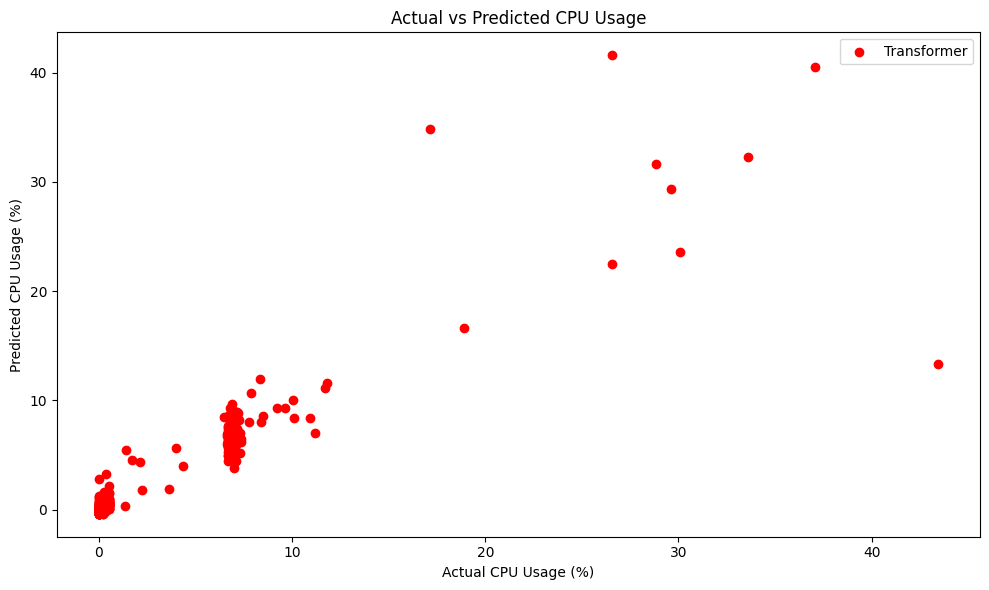

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='red', label='Transformer')
plt.xlabel('Actual CPU Usage (%)')
plt.ylabel('Predicted CPU Usage (%)')
plt.title('Actual vs Predicted CPU Usage')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
def generate_future_predictions(num_periods=5):
    last_data = data_cleaned.iloc[-1]
    future_predictions = []
    for i in range(num_periods):
        # Using the last values to predict the next ones
        future_data = last_data[['\tMemory usage [KB]', '\tDisk read throughput [KB/s]',
                                 '\tDisk write throughput [KB/s]', '\tNetwork received throughput [KB/s]',
                                 '\tNetwork transmitted throughput [KB/s]']].values.reshape(1, -1)

        # Convert future_data to numeric type before creating a tensor
        future_data = future_data.astype(np.float32)  # or another suitable numeric type

        future_data_tensor = torch.tensor(future_data, dtype=torch.float32)
        predicted_cpu_usage = model_transformer(future_data_tensor).detach().numpy()[0][0]

        future_timestamp = last_data['Timestamp'] + pd.Timedelta(minutes=5 * (i + 1))  # Assuming 5-minute intervals
        future_predictions.append([future_timestamp, predicted_cpu_usage])

    future_df = pd.DataFrame(future_predictions, columns=['Timestamp', 'Predicted CPU Usage [%]'])
    return future_df

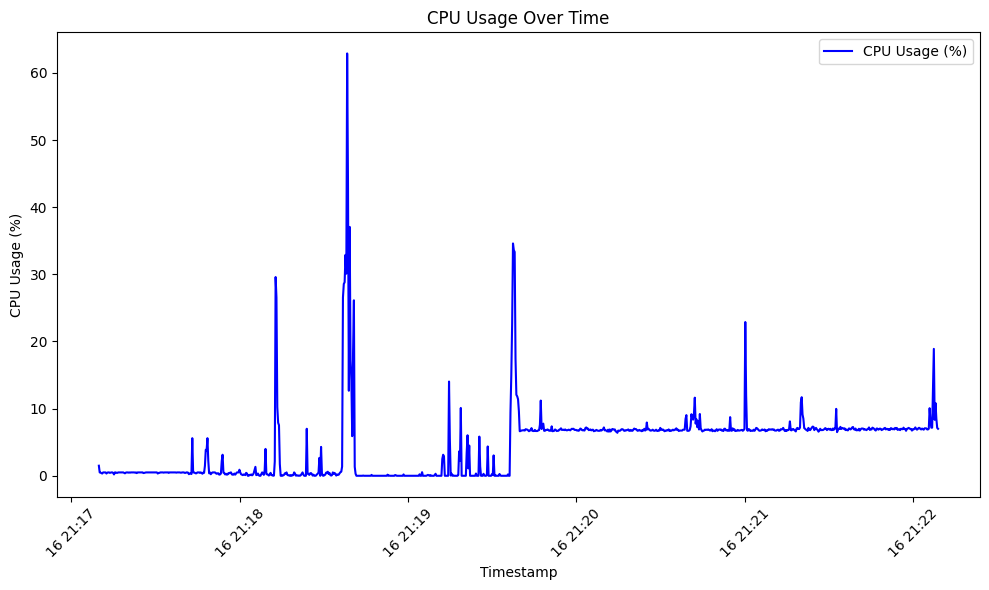

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Timestamp'], data_cleaned['\tCPU usage [%]'], color='b', label='CPU Usage (%)')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.title('CPU Usage Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

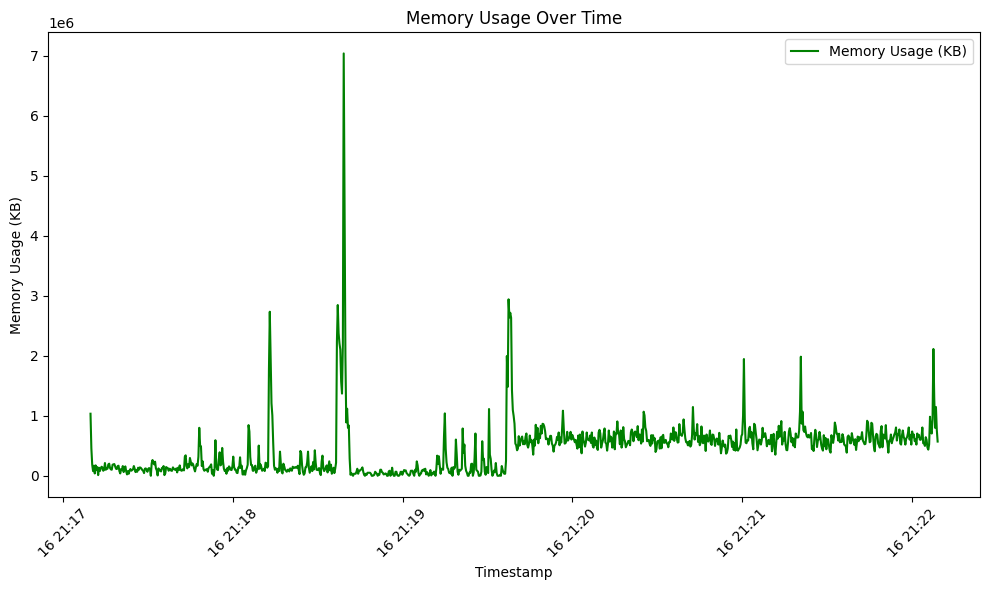

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Timestamp'], data_cleaned['\tMemory usage [KB]'], color='g', label='Memory Usage (KB)')
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage (KB)')
plt.title('Memory Usage Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

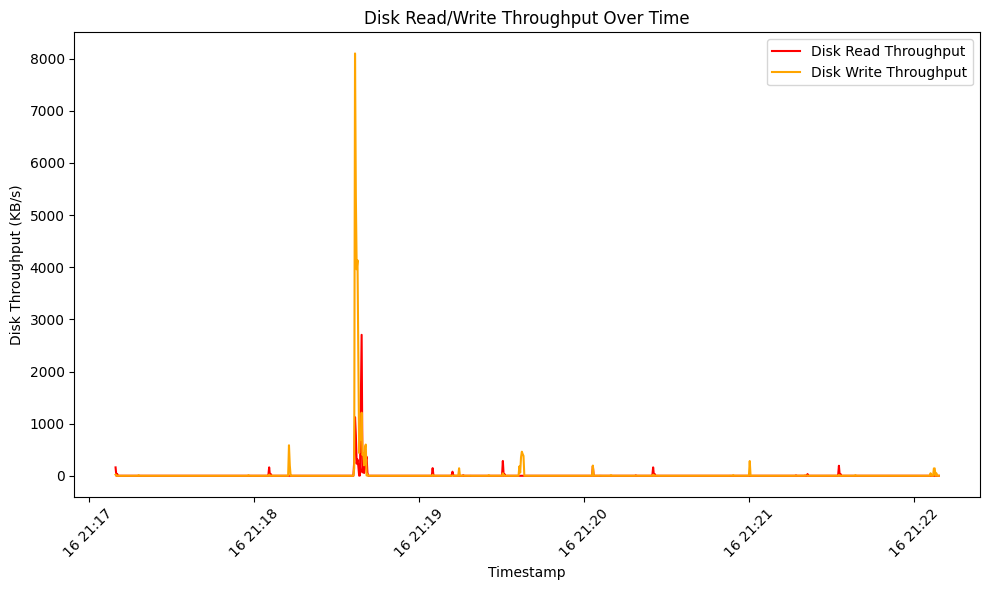

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Timestamp'], data_cleaned['\tDisk read throughput [KB/s]'], color='r', label='Disk Read Throughput')
plt.plot(data_cleaned['Timestamp'], data_cleaned['\tDisk write throughput [KB/s]'], color='orange', label='Disk Write Throughput')
plt.xlabel('Timestamp')
plt.ylabel('Disk Throughput (KB/s)')
plt.title('Disk Read/Write Throughput Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 9 (	) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


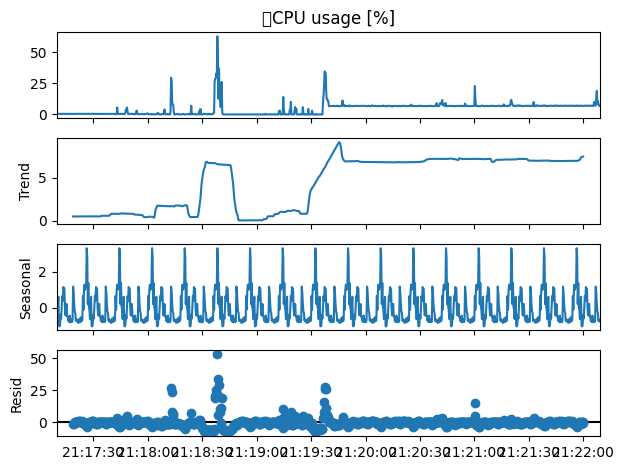

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/seasonal.py:360: UserWarning: Glyph 9 (	) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


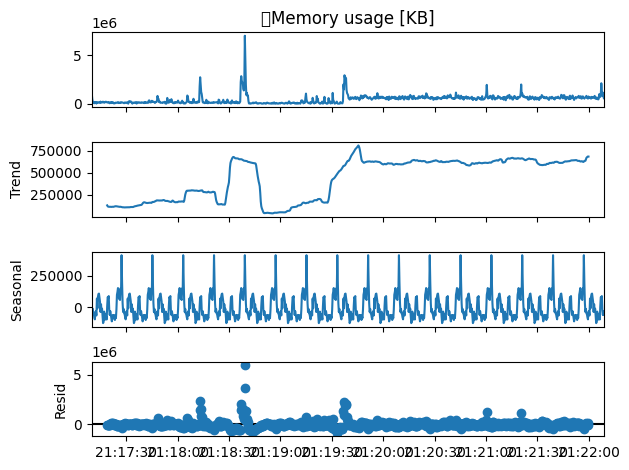

In [51]:
import statsmodels.api as sm


cpu_ts = data_cleaned.set_index('Timestamp')['\tCPU usage [%]']  # Added a tab character

decomposition = sm.tsa.seasonal_decompose(cpu_ts, model='additive', period=60)
decomposition.plot()
plt.show()

# Decompose the Memory usage time series
# Similarly, check and adjust the memory usage column name if necessary
memory_ts = data_cleaned.set_index('Timestamp')['\tMemory usage [KB]']  # Added a tab character

decomposition_memory = sm.tsa.seasonal_decompose(memory_ts, model='additive', period=60)
decomposition_memory.plot()
plt.show()